In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [2]:
try:
    df = pd.read_csv("data_generation\dataset.csv")
except:
    print('c')

In [3]:
df.head()

,headline,label
0,Kal ka plan final hai na Time pe pahuch jaana,0
1,Tune suna Sharma ji ka beta first aaya exams m...,0
2,Chalo beach pe chalte hain weekend par maza aa...,0
3,Tu itna late kyun ho gaya aaj Traffic tha kya,0
4,Woh new series dekhi kya Netflix par Bahut ac...,0


In [4]:
df['label'].unique()

array([0, 1], dtype=int64)

below function for visualizing the dataset using pie chart. df has column label with entries 0 and 1 which corresponds to bullying and not bullying label.                   
df.shape gives a tuple with the dimensions of the dataframe                
df[df['title']condition] selects only enters which satisfies the condition
slices has the fraction of wach slice in list to give proportion to the pie chart                             
autopct in plt.pie formats the percentages displayed on the chart, in this case 1 decimal place                     
wedgeprops adds a black around each wedge             
tight_layout so that everything is adjusted within the figure

In [5]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Bullying', 'Not Bullying']
    
    explode = [0.1, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Bullying Vs Not Bullying Sample')
    
    plt.tight_layout()
    
    plt.show()

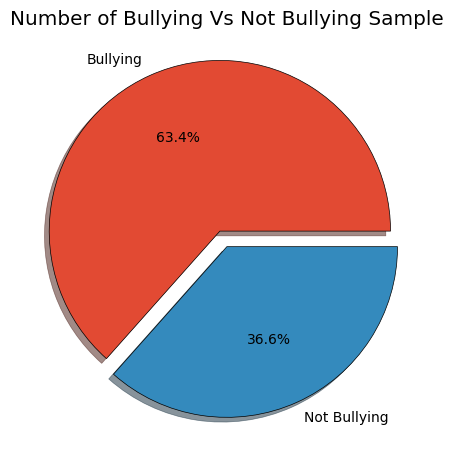

In [6]:
performdatadistribution(df)

In [7]:
from sklearn.model_selection import train_test_split

stop words are words typically removed in text processing since they are non informative
Tfidvectorizer object removes stop words during processing and changes text to lowercase
fit_transform fits the vectorizer to the training data and traforms the text into a sparse matrix of TF-IDF(term frequency-Inverse document frequency) features.
.values.astype('U')ensures text is in Unicode format
transform is used to convert the test data into same feature space as training data without fitting the vectorizer again
pickle file stores the vocabulary of TF-IDF vectorizer to a file.
this file is important when transforming unseen text. by saving it to a file we can load the same vocabulary during deployment

In [8]:
def performdatasplit(x, y, df):
    X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r",encoding='UTF-8')
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [9]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, df)

Number of rows in the total dataset: 4102
Number of rows in the train dataset: 3281
Number of rows in the test dataset: 821


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad', 'अद', 'अपन', 'अभ', 'आद', 'इत', 'इतय', 'इनक', 'इसक', 'इसम', 'उनक', 'उसक', 'एव', 'ऐस', 'करत', 'करन', 'कह', 'कहत', 'गय', 'जह', 'तन', 'तर', 'दब', 'दर', 'दव', 'धर', 'नस', 'नह', 'पहल', 'बन', 'बह', 'यत', 'यद', 'रख', 'रव', 'रह', 'लक', 'वग', 'वर', 'वग़', 'सकत', 'सबस', 'सभ', 'सर'] not in stop_words.
  warnings.warn(


In [10]:
#import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [11]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result
        

In [12]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training LinearSVC finished in 0.345714807510376 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 0.33699989318847656 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.0 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 2.885694742202759 sec
Training Time : AdaBoostClassifier
Training AdaBoostClassifier finished in 1.567277431488037 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 19.181326150894165 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.11670064926147461 sec


In [13]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [14]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,LinearSVC,0.345715,0.031815,0.807552,0.955806,0.720848,0.936984,0.790698,0.972047,0.662338,0.904362
1,SGDClassifier,0.116701,0.001000,0.799026,0.950320,0.708995,0.928540,0.776062,0.972452,0.652597,0.888423
2,DecisionTreeClassifier,2.885695,0.000000,0.750305,0.998171,0.643478,0.997477,0.692884,1.000000,0.600649,0.994966
3,BaggingClassifier,19.181326,0.049631,0.755177,0.975922,0.629834,0.966051,0.727660,0.990308,0.555195,0.942953
4,LogisticRegression,0.337000,0.000000,0.778319,0.839378,0.623967,0.726518,0.857955,0.952381,0.490260,0.587248
5,AdaBoostClassifier,1.567277,0.099594,0.751523,0.806766,0.583673,0.667366,0.785714,0.890756,0.464286,0.533557
6,MultinomialNB,0.000000,0.002000,0.772229,0.833892,0.581655,0.709023,0.935252,0.975037,0.422078,0.557047


In [15]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.000000,0.000000,0.750305,0.806766,0.581655,0.667366,0.692884,0.890756,0.422078,0.533557
max,19.181326,0.099594,0.807552,0.998171,0.720848,0.997477,0.935252,1.000000,0.662338,0.994966


GRAPH REPRESENTATION

Text(0.5, 1.0, 'Classification Summary of Algorithms')

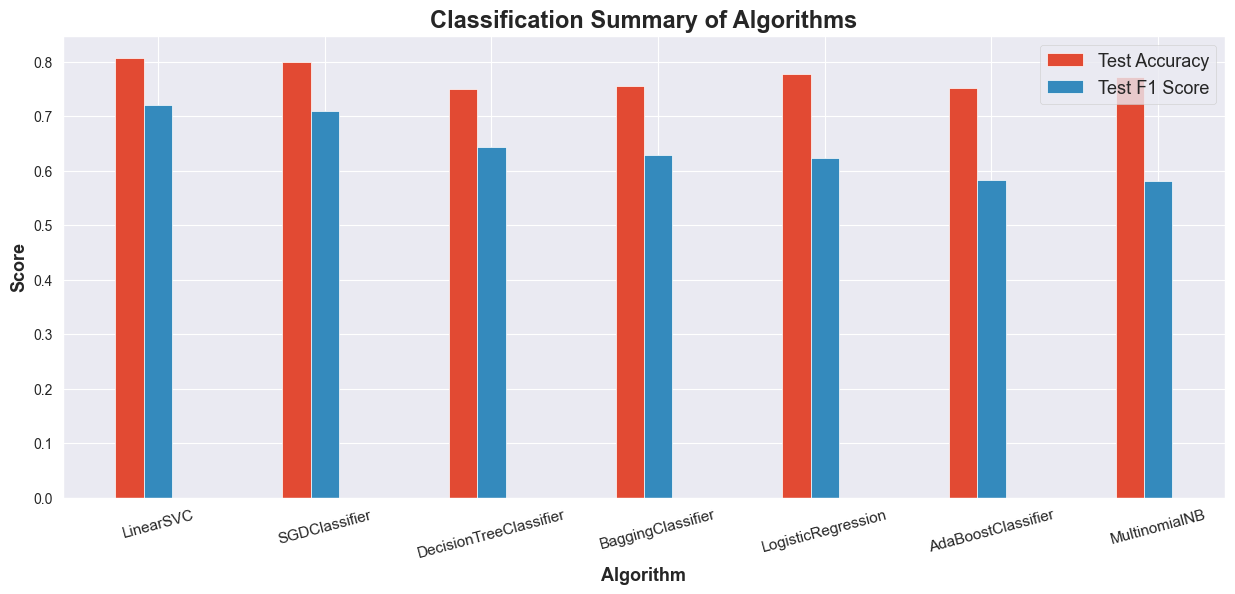

In [16]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17)

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

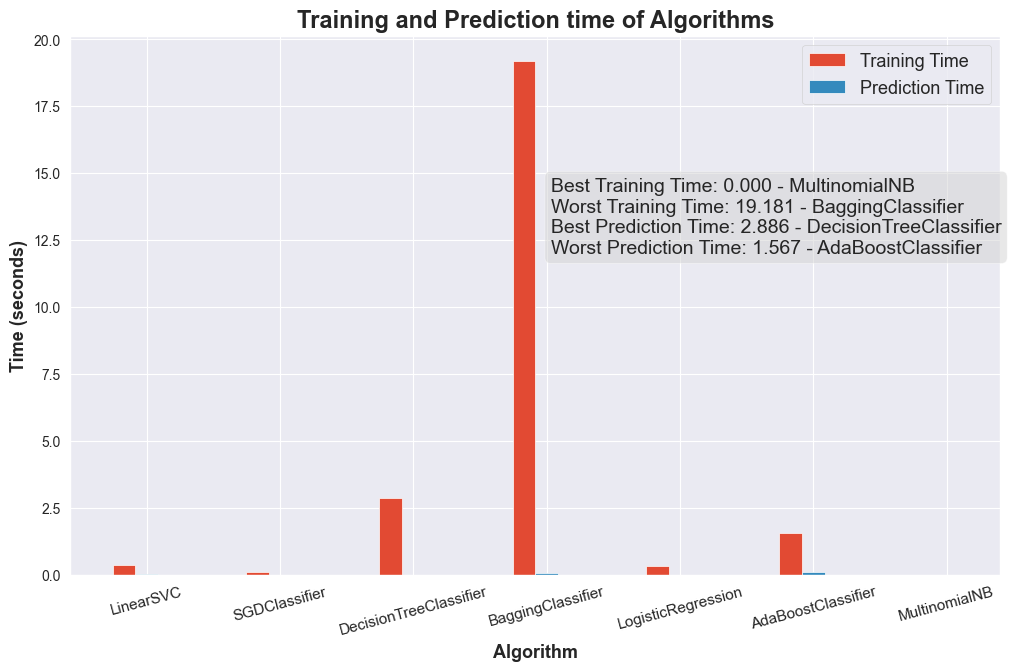

In [17]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [18]:
df.head()

,headline,label
0,Kal ka plan final hai na Time pe pahuch jaana,0
1,Tune suna Sharma ji ka beta first aaya exams m...,0
2,Chalo beach pe chalte hain weekend par maza aa...,0
3,Tu itna late kyun ho gaya aaj Traffic tha kya,0
4,Woh new series dekhi kya Netflix par Bahut ac...,0


In [19]:
data = ["tum kitni ache kaise he"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bullying")
else:
    print("non-bullying")

[0]
non-bullying


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad', 'अद', 'अपन', 'अभ', 'आद', 'इत', 'इतय', 'इनक', 'इसक', 'इसम', 'उनक', 'उसक', 'एव', 'ऐस', 'करत', 'करन', 'कह', 'कहत', 'गय', 'जह', 'तन', 'तर', 'दब', 'दर', 'दव', 'धर', 'नस', 'नह', 'पहल', 'बन', 'बह', 'यत', 'यद', 'रख', 'रव', 'रह', 'लक', 'वग', 'वर', 'वग़', 'सकत', 'सबस', 'सभ', 'सर'] not in stop_words.
  warnings.warn(


In [20]:
from sklearn.model_selection import GridSearchCV

def tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [21]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuning(clf_model, param_grid, training_data, y_train, testing_data, y_test)

c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.8087697929354446
F1 Score :  0.7240773286467486
Precision :  0.789272030651341
Recall:  0.6688311688311688


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

In [22]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))

In [31]:
from sklearn.ensemble import VotingClassifier

# Combine accuracy and F1 score into a custom weight (e.g., simple average or a weighted average)
def voting_classifier(X_train, y_train, X_test, y_test):
    # Ensure final_result is defined and contains accuracy, precision, and F1 score for each model
    custom_weights = []

    # Loop through final_result and compute custom weights for each model
    for result in final_result:
        # Calculate the custom weight using the average of accuracy, precision, and F1 score
        accuracy = result.get('Accuracy : Test', 0)
        precision = result.get('Precision : Test', 0)
        f1_score_test = result.get('F1 Score : Test', 0)
        
        # You can adjust the formula here; this is just an example
        weight = (accuracy + precision + f1_score_test) / 3
        custom_weights.append(weight)

    print(f"Custom Weights: {custom_weights}")

    # Ensure the number of weights matches the number of classifiers in VotingClassifier
    models = [
        ('svct', pickle.load(open("LinearSVCTuned.pkl", 'rb'))),
        ('lr', pickle.load(open("LogisticRegression.pkl", 'rb'))),
        ('nb', pickle.load(open("MultinomialNB.pkl", 'rb'))),
        ('dt', pickle.load(open("DecisionTreeClassifier.pkl", 'rb'))),
        ('ada', pickle.load(open("AdaBoostClassifier.pkl", 'rb'))),
        ('bagging', pickle.load(open("BaggingClassifier.pkl", 'rb'))),
        ('sgd', pickle.load(open("SGDClassifier.pkl", 'rb')))
    ]

    

    # Check that the number of weights matches the number of models
    if len(custom_weights) != len(models):
        raise ValueError("The number of custom weights must match the number of models.")

    # Create the VotingClassifier with hard voting and custom weights
    voting_clf = VotingClassifier(
        estimators=models,
        voting='hard',
        weights=custom_weights
    )

    # Fit the ensemble model
    voting_clf.fit(X_train, y_train)

    #save model
    pickle.dump(voting_clf, open("voting_classifier.pkl", "wb"))

    # Make predictions
    y_pred = voting_clf.predict(X_test)

    # Calculate and print the evaluation metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")

In [32]:
voting_classifier(training_data, y_train, testing_data, y_test)

Custom Weights: [0.7730324990315207, 0.7534135368746707, 0.7630454228610833, 0.6955555542332662, 0.7069700961992592, 0.7042234808324124, 0.7613606878730711]


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7917174177831913
F1 Score: 0.7783090040662279
Precision: 0.803291556526979
Recall: 0.7917174177831913


In [33]:
data = ["दिल्ली वालो आप के सातों को हरा दो ये कजरी के सपोर्टर हारने चाहिए"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('voting_classifier.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bullying")
else:
    print("non-bullying")

[1]
bullying


c:\Users\Aishu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad', 'अद', 'अपन', 'अभ', 'आद', 'इत', 'इतय', 'इनक', 'इसक', 'इसम', 'उनक', 'उसक', 'एव', 'ऐस', 'करत', 'करन', 'कह', 'कहत', 'गय', 'जह', 'तन', 'तर', 'दब', 'दर', 'दव', 'धर', 'नस', 'नह', 'पहल', 'बन', 'बह', 'यत', 'यद', 'रख', 'रव', 'रह', 'लक', 'वग', 'वर', 'वग़', 'सकत', 'सबस', 'सभ', 'सर'] not in stop_words.
  warnings.warn(
